# CS231a PSET 4 Problem 4: Linear Kalman Filter with a Learned Inverse Observation Model

Building on the idea of learning useful representations for downstream tasks we saw in the last problem, in this problem you will see how this can be done for the task of monocular depth estimation.

**Using a GPU**. Make sure to first change your runtime to use a GPU: click Runtime -> Change runtime type -> Hardware Accelerator -> GPU and your Colab instance will automatically be backed by GPU compute.

Note: there is a known issue of the RAM running out while loading the second set of data after training. To get around this, after training please just restart the runtime and rerun the first 3 cells (prior to loading the training data) followed by the cells under 'Using the model'.

In [1]:
# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

# # enter the foldername in your Drive where you have saved the data
# # folder from the pset folder
# # e.g. 'cs231a/ps4'
FOLDERNAME = 'ps4_code/ps4_code'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cd $FOLDERNAME
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

[Errno 2] No such file or directory: 'drive/My Drive'
/content
/content/ps4_code/ps4_code


In [ ]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [2]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import gc
import time

# Loading the data for part A

Let's start by loading our datasets into memory:


In [ ]:
# def load_dataset(root, split="train"):
#     labels = np.load(root + 'Q4A_positions_'+split+'.npy')
#     num_images = labels.shape[0]//2
#     images = np.empty(shape=(num_images, 480, 640,3))
#     for i in tqdm(range(num_images), desc='Loading data'):
#         im = Image.open(root + 'img_%03d_%s.png'%(i,split))
#         images[i] = np.array(im)/255.0
#     return images, labels[:num_images]

# image_train, label_train = load_dataset('data/Q4A_data/training_set/', 'train')
# image_test, label_test = load_dataset('data/Q4A_data/testing_set/', 'test')

from torch.utils.data import Dataset, Subset
class CustomImageDataset(Dataset):
    def __init__(self, root, split="train", transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        self.labels = np.load(os.path.join(root, f'Q4A_positions_{split}.npy'))
        self.num_images = self.labels.shape[0]

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, f'img_{idx:03d}_{self.split}.png')
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
          image = np.array(image) / 255.0
          image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # HWC to CHW

        return image, label

train_dataset = CustomImageDataset(root='data/Q4A_data/training_set/', split='train')
test_dataset = CustomImageDataset(root='data/Q4A_data/testing_set/', split='test')

train_indices = np.random.randint(len(train_dataset), size=int(len(train_dataset)))

# subset_train_dataset = Subset(train_dataset, train_indices)

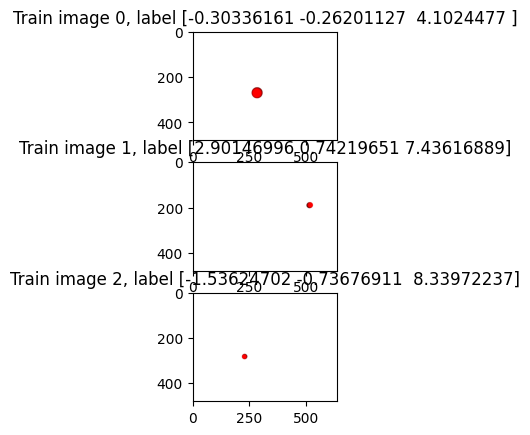

In [ ]:
n = 3
fig, axs = plt.subplots(n)
for i in range(n):
    idx = i
    img = train_dataset[idx][0].permute(1, 2, 0).numpy()
    axs[i].imshow(img)
    axs[i].set_title('Train image %d, label %s'%(idx,str(train_dataset[idx][1])))

# Training the Model

Next, we can go ahead and train the model:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ObservationModel(nn.Module):
    def __init__(self):
        super(ObservationModel, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(128)
        self.conv3_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 2, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.conv3_3(x)

        N, C, H, W = x.shape
        features = x.view(N, C, -1).permute(0, 2, 1).contiguous().view(-1, C)
        softmax = F.softmax(features, dim=1)
        softmax = softmax.view(N, H, W, C).permute(0, 3, 1, 2).unsqueeze(-1)

        posx, posy = torch.meshgrid(torch.linspace(-1., 1., H), torch.linspace(-1., 1., W), indexing='ij')
        posx = posx.view(1, 1, H, W, 1).to(x.device)
        posy = posy.view(1, 1, H, W, 1).to(x.device)
        image_coords = torch.cat([posx, posy], dim=-1)

        feature_points = torch.sum(softmax * image_coords, dim=[2, 3])
        feature_points = feature_points.view(N, C * 2)

        x = F.relu(self.bn_fc1(self.fc1(feature_points)))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x

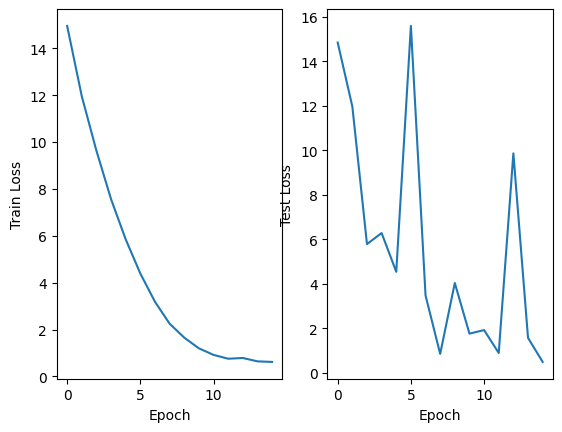

Final training loss:  0.6170044938723246
Final testing loss:  0.49671702299799236


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming make_model is a function that returns an instance of a PyTorch model
model = ObservationModel().cuda()
criterion = nn.MSELoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

batch_size = 16
num_epochs = 15

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# If using an M2/M3 Macbook, uncomment the following line
# device = torch.device("mps")

# Convert data to PyTorch tensors
# %xdel train_dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_losses = []
test_losses = []

model.to(device)

for epoch in tqdm(range(num_epochs), desc='Training'):
    model.train()
    train_loss = 0.0
    for batch_image_train, batch_label_train in train_loader:
        batch_image_train, batch_label_train = batch_image_train.cuda().float(), batch_label_train.cuda().float()
        optimizer.zero_grad()
        predict = model(batch_image_train)
        loss = criterion(predict, batch_label_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_image_test, batch_label_test in test_loader:
            batch_image_test, batch_label_test = batch_image_test.cuda().float(), batch_label_test.cuda().float()
            predict = model(batch_image_test)
            loss = criterion(predict, batch_label_test)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    torch.save(model.state_dict(), 'trained_model.pth')
    if epoch > 1:
        clear_output()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(train_losses)
        ax2.plot(test_losses)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Train Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Test Loss')
        plt.show()

print("Final training loss: ", train_losses[-1])
print("Final testing loss: ", test_losses[-1])


In [ ]:
# run if using Colab and want to save memory
%xdel image_train
%xdel image_test
gc.collect()

NameError: name 'image_train' is not defined
NameError: name 'image_test' is not defined


62575

# Using the Model

Now, let's use the model to make predictions for our Kalman Filter. Note that you may have to restart the runtime if your RAM runs out; just run the things up to 'Loading the data for part A' and then skip to this section.

In [ ]:
# def load_dataset():
#     labels = np.load('./data/Q4B_data/Q4B_positions_gt.npy')
#     num_images = labels.shape[0]
#     images = np.empty(shape=(num_images, 480, 640,3))
#     for i in tqdm(range(num_images),desc="Loading data"):
#         im = Image.open('./data/Q4B_data/img_%03d.png'%(i))
#         images[i] = np.array(im)/255.0
#     return images, labels

# image_infer, label_infer = load_dataset()
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.data import Dataset, DataLoader

class InferenceDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        question = self.root.split('/')[2].split('_')[0]
        self.labels = np.load(os.path.join(root, f'{question}_positions_gt.npy'))
        self.num_images = self.labels.shape[0]

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, f'img_{idx:03d}.png')
        image = Image.open(img_path).convert("RGB")
        # label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = np.array(image) / 255.0
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # HWC to CHW

        return image

# Usage example
root = './data/Q4B_data/'
dataset = InferenceDataset(root)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
# model.eval()  # Set the model to evaluation mode
model = ObservationModel()
model.load_state_dict(torch.load('trained_model.pth'))
model.to(device="cuda")
model.eval()

predictions_val = []
label_infer = np.load('./data/Q4B_data/Q4B_positions_gt.npy')

with torch.no_grad():  # Disable gradient calculation
    for img in tqdm(dataloader, desc="Processing"):
        img = img.to(device)
        pred_val = model(img)
        predictions_val.append(pred_val.squeeze().cpu().numpy())

predictions_val = np.array(predictions_val)
print('Mean error: ' + str(np.mean(np.linalg.norm(label_infer - predictions_val, axis=1))))
np.save('./data/Q4B_predictions.npy', predictions_val)

Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

Mean error: 0.8095797308361429


In [ ]:
# run if using Colab or want to save local memory

%xdel dataset
gc.collect()

9

In [ ]:
# def load_dataset():
#     labels = np.load('./data/Q4D_data/Q4D_positions_gt.npy')
#     num_images = labels.shape[0]
#     images = np.empty(shape=(num_images, 480, 640,3))
#     for i in tqdm(range(num_images),desc="Loading data"):
#         im = Image.open('./data/Q4D_data/img_%03d.png'%(i))
#         images[i] = np.array(im)/255.0
#     return images, labels

# image_infer, label_infer = load_dataset()
root = './data/Q4D_data/'
dataset = InferenceDataset(root)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
model = ObservationModel()
model.load_state_dict(torch.load('trained_model.pth'))
model.to(device="cuda")
model.eval()

predictions_val = []
label_infer = np.load('./data/Q4D_data/Q4D_positions_gt.npy')

with torch.no_grad():  # Disable gradient calculation
    for img in tqdm(dataloader, desc="Processing"):
        img = img.to(device)
        pred_val = model(img)
        predictions_val.append(pred_val.squeeze().cpu().numpy())

predictions_val = np.array(predictions_val)
print('Mean error: ' + str(np.mean(np.linalg.norm(label_infer - predictions_val, axis=1))))
np.save('./data/Q4D_predictions.npy', predictions_val)

Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

Mean error: 0.9734415013656919


# Finishing Problem 4
Now that you have the predictions .npy files, you can use these along with the completed code in p4.py to generate the plots needed for the PDF report. Congratulations on finishing the last 231a PSET!